In [ ]:
import warnings
warnings.filterwarnings('ignore')

C:\Users\rgaletta\AppData\Local\Temp\ipykernel_6832\583021258.py:56: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gp.read_file(out_shp).buffer(-0.3).buffer(0.3).plot(cmap = 'plasma', ax = axs[2])
C:\Users\rgaletta\AppData\Local\Temp\ipykernel_6832\583021258.py:56: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gp.read_file(out_shp).buffer(-0.3).buffer(0.3).plot(cmap = 'plasma', ax = axs[2])


<Axes: title={'center': 'lissage sans topo.'}>

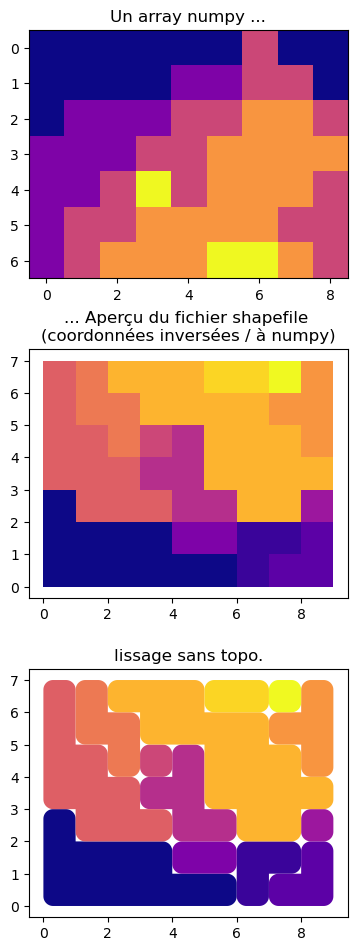

In [62]:
# 1- Exemple minimal : on s'affranchit de la gestion de coordonnées du fichier vecteur...

import matplotlib.pyplot as plt
import numpy as np

from shapely.geometry import Polygon, mapping
from rasterio.features import shapes
import fiona
from fiona.crs import from_epsg

import geopandas as gp

# epsg
epsg = 4326

# Un array avec des motifs à trous.
l1 = [
    [1,1,1,1,1,1,3,1,1],
    [1,1,1,1,2,2,3,3,1],
    [1,2,2,2,3,3,4,4,3],
    [2,2,2,3,3,4,4,4,4],
    [2,2,3,5,3,4,4,4,3],
    [2,3,3,4,4,4,4,3,3],
    [2,3,4,4,4,5,5,4,3],
]

nd_arr = np.array(l1)

## DEBUT Gestion affichage
fig, axs = plt.subplots(3)
plt.rcParams["figure.figsize"] = (20,10)
fig.tight_layout(pad=3.0)
axs[0].set_title('Un array numpy ...')
axs[0].imshow(nd_arr, cmap='plasma')
## FIN Gestion affichage

schema = {
    'geometry': 'Polygon',
    'properties': {
        'val': 'int'
    }
}
out_shp = '_files/your_shapefile.shp'

with fiona.open(out_shp, 'w', crs=from_epsg(4326), driver='ESRI Shapefile', schema=schema) as output:
    for sh in shapes(nd_arr):
        p, val = sh[0]['coordinates'][0], int(sh[1]) 
        poly = Polygon(p)
        output.write({'geometry': mapping(poly), 'properties': {'val': val}})

axs[1].set_title('... Aperçu du fichier shapefile \n(coordonnées inversées / à numpy)')
gp.read_file(out_shp).plot(cmap = 'plasma', ax = axs[1])

# Lissage grossier (en sus : utiliser topojs pour supprimer les trous) :
axs[2].set_title('lissage sans topo.')
gp.read_file(out_shp).buffer(-0.3).buffer(0.3).plot(cmap = 'plasma', ax = axs[2])

In [ ]:
# 2- Conversion à partir de raster

import rasterio as rio

rst_f = '_files/1-7967-22978_amax.tif'

